# Import packages

In [1]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import sklearn
import scipy
import seaborn as sns
from datetime import datetime, timedelta

!pip install xgboost

# Load Data

In [2]:
df_logins = pd.read_csv('takehome_user_engagement.csv')
df_logins.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [3]:
df_users = pd.read_csv('takehome_users.csv', sep=',', header=0 , encoding = "latin_1")
df_users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


# Data Wrangling

## Create New Column for adopted users

In [4]:
sorted(list(df_logins['visited'].unique()))

[1]

In [5]:
# Count how many unique users in our engagment data of the 207,917 entries 
print('There are {} unique users of the 207,917 entries in engagement data'\
      .format(len(df_logins['user_id'].unique())))

There are 8823 unique users of the 207,917 entries in engagement data


In [6]:
# Narrowing down the data to just users who logged in 3 or more times from df_logins

three_logins = df_logins.groupby('user_id').filter(lambda x: len(x) >=3)
print('There are {} unique users who logged in 3 times or more in total'\
      .format(len(three_logins['user_id'].unique())))

three_logins.head(3)

There are 2248 unique users who logged in 3 times or more in total


,time_stamp,user_id,visited
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1


In [7]:
# Remove index
three_logins.reset_index(drop=True, inplace = True)

# Find how many of the 2248 unique three-logins users are adopted users 
# who have logged in three separate days in at least one 7 day period 
# Using three_logins

adopted = 0
adopted_users = []
for i in range(len(three_logins)-2):
    user = three_logins['user_id'][i]
    if user != adopted and user == three_logins['user_id'][i+2]:
    # Get start date 
        sd = pd.Timestamp(three_logins['time_stamp'][i])
        # 7 days period end date
        ed = sd + pd.Timedelta('7D')
        if sd < pd.Timestamp(three_logins['time_stamp'][i+1]) < ed and sd < \
        pd.Timestamp(three_logins['time_stamp'][i+2]) < ed:
            adopted_users.append(user)
            adopted = user

# Count how many adopted users there are 
print('There are {} adopted users.'\
      .format(len(adopted_users)))

There are 1602 adopted users.


In [8]:
# Add our new adopted_users feature to df_users: 1 for adopted and 0 for not-adopted

y = pd.Series(np.random.randn(len(df_users)))
n = 0
for i in range(len(df_users)):
    if df_users['object_id'][i] == adopted_users[n]:
        y[i] = 1
        n = n+1
        if n > len(adopted_users)-1:
            n = n -1
    else:
        y[i] = 0
        
users2 = pd.DataFrame(y, columns = ['adopted_user'])
df_users = pd.concat([df_users, users2], axis=1)

In [9]:
print((df_users[df_users['adopted_user'] == 1]).count())

object_id                     1602
creation_time                 1602
name                          1602
email                         1602
creation_source               1602
last_session_creation_time    1602
opted_in_to_mailing_list      1602
enabled_for_marketing_drip    1602
org_id                        1602
invited_by_user_id             913
adopted_user                  1602
dtype: int64


## Create new column for invited or non-invited users

In [10]:
# We see above that some users were not invited by another user
# Construct another feature of invited: 1 for invited and 0 for wasn't invited 
inv = pd.Series(np.random.randn(len(df_users)))
for i in range(len(df_users)):
    if df_users['invited_by_user_id'][i] >=1:
        inv[i] = 1
    else:
        inv[i] = 0
df_users2 = pd.DataFrame(inv, columns = ['invited'])
df_users = pd.concat([df_users,df_users2], axis = 1)
df_users

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,invited
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0.0,1.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1.0,1.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0.0,1.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0.0,1.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
11995,11996,2013-09-06 06:14:15,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,1.378448e+09,0,0,89,8263.0,0.0,1.0
11996,11997,2013-01-10 18:28:37,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,1.358275e+09,0,0,200,NaN,0.0,0.0
11997,11998,2014-04-27 12:45:16,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,1.398603e+09,1,1,83,8074.0,0.0,1.0
11998,11999,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,1.338638e+09,0,0,6,NaN,0.0,0.0


## Merge Dataframes

In [11]:
print(df_logins.info())
print(df_users.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   ena

#### After inspecting the data, it looks like the user_id column from df is the same as the oject_id column from df2. We can merge the dataframe by the user_id but we need to rename the column from df2.

In [12]:
df_users = df_users.rename(columns={"object_id": "user_id"})
df_users.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,invited
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0.0,1.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1.0,1.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0.0,1.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0.0,1.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0.0,1.0


In [13]:
df_logins.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [14]:
data = pd.merge(df_users, df_logins, on='user_id')
data.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,invited,time_stamp,visited
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0.0,1.0,2014-04-22 03:53:30,1
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1.0,1.0,2013-11-15 03:45:04,1
2,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1.0,1.0,2013-11-29 03:45:04,1
3,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1.0,1.0,2013-12-09 03:45:04,1
4,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1.0,1.0,2013-12-25 03:45:04,1


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 207917 entries, 0 to 207916
Data columns (total 14 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   user_id                     207917 non-null  int64  
 1   creation_time               207917 non-null  object 
 2   name                        207917 non-null  object 
 3   email                       207917 non-null  object 
 4   creation_source             207917 non-null  object 
 5   last_session_creation_time  207917 non-null  float64
 6   opted_in_to_mailing_list    207917 non-null  int64  
 7   enabled_for_marketing_drip  207917 non-null  int64  
 8   org_id                      207917 non-null  int64  
 9   invited_by_user_id          116887 non-null  float64
 10  adopted_user                207917 non-null  float64
 11  invited                     207917 non-null  float64
 12  time_stamp                  207917 non-null  object 
 13  visited       

## Change datatypes

In [16]:
# Convert Dates to datetime64
data['time_stamp'] = pd.to_datetime(data['time_stamp'])
data['creation_time'] = pd.to_datetime(data['creation_time'])
data['last_session_creation_time'] = pd.to_datetime(data['last_session_creation_time'],unit='s')

# Convert adopted_user and invited to int
print(len(data), len(data.adopted_user.notnull()))
data['adopted_user'] = data['adopted_user'].astype(int)
data['invited'] = data['invited'].astype(int)

data.info()

207917 207917
<class 'pandas.core.frame.DataFrame'>
Int64Index: 207917 entries, 0 to 207916
Data columns (total 14 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   user_id                     207917 non-null  int64         
 1   creation_time               207917 non-null  datetime64[ns]
 2   name                        207917 non-null  object        
 3   email                       207917 non-null  object        
 4   creation_source             207917 non-null  object        
 5   last_session_creation_time  207917 non-null  datetime64[ns]
 6   opted_in_to_mailing_list    207917 non-null  int64         
 7   enabled_for_marketing_drip  207917 non-null  int64         
 8   org_id                      207917 non-null  int64         
 9   invited_by_user_id          116887 non-null  float64       
 10  adopted_user                207917 non-null  int64         
 11  invited                  

In [17]:
data.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,invited,time_stamp,visited
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0,1,2014-04-22 03:53:30,1
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1,1,2013-11-15 03:45:04,1
2,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1,1,2013-11-29 03:45:04,1
3,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1,1,2013-12-09 03:45:04,1
4,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1,1,2013-12-25 03:45:04,1


# Predictive Modeling
After defining our adopted users, we will now aim to identify which factors predict future users adoption using a classification machine learning model.

## One-hot encode categorical variables

In [18]:
# We will first use one-hot encoding to transform our categorical features 
data['creation_source'].value_counts()

ORG_INVITE            70091
GUEST_INVITE          46796
SIGNUP                37545
SIGNUP_GOOGLE_AUTH    34263
PERSONAL_PROJECTS     19222
Name: creation_source, dtype: int64

In [19]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(['ORG_INVITE','GUEST_INVITE','PERSONAL_PROJECTS','SIGNUP','SIGNUP_GOOGLE_AUTH'])

LabelEncoder()

In [20]:
creation_src = le.transform(data['creation_source'])

In [21]:
df4 = pd.DataFrame(creation_src, columns = ['creation'])
data = pd.concat([data ,df4], axis=1)
data.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,invited,time_stamp,visited,creation
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0,1,2014-04-22 03:53:30,1,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1,1,2013-11-15 03:45:04,1,1
2,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1,1,2013-11-29 03:45:04,1,1
3,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1,1,2013-12-09 03:45:04,1,1
4,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1,1,2013-12-25 03:45:04,1,1


## Use Extreme Gradient Boost (XGBoost) Classification Model

In [22]:
# Import Extreme Gradient Boosting Classification Model 
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Create axes for labels and features
y = data['adopted_user']
X = data[['creation','opted_in_to_mailing_list','enabled_for_marketing_drip','org_id']]

# split data into train and test sets
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

In [23]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 207917 entries, 0 to 207916
Data columns (total 4 columns):
 #   Column                      Non-Null Count   Dtype
---  ------                      --------------   -----
 0   creation                    207917 non-null  int64
 1   opted_in_to_mailing_list    207917 non-null  int64
 2   enabled_for_marketing_drip  207917 non-null  int64
 3   org_id                      207917 non-null  int64
dtypes: int64(4)
memory usage: 7.9 MB


In [24]:
# fit model to training data
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [25]:
X.columns

Index(['creation', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip',
       'org_id'],
      dtype='object')

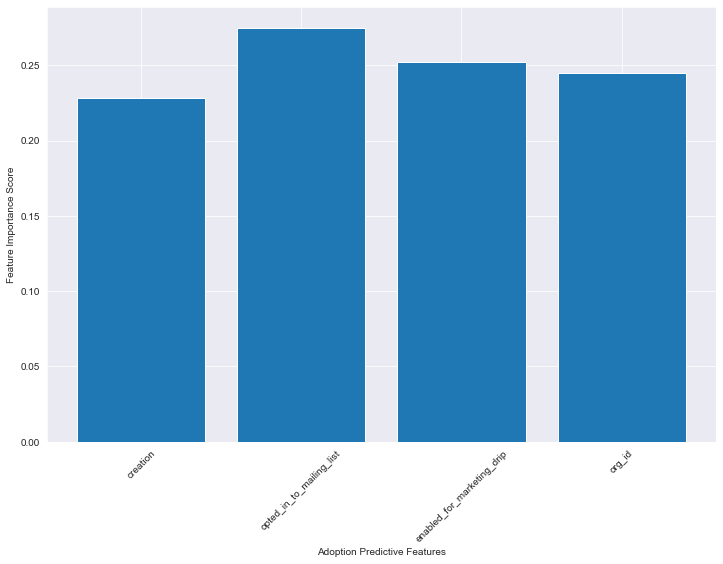

In [26]:
# Plot the feature importances for our target label of adopted users 
feat_imp = model.feature_importances_
sns.set_style("darkgrid")
plt.figure(figsize=(12,8))
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
xcol = X.columns
plt.xlabel('Adoption Predictive Features')
plt.ylabel('Feature Importance Score')
plt.xticks(range(len(xcol)), xcol.values, rotation=45)
plt.show()



In [27]:
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 96.09%
